In [1]:
from google.colab import drive
import os

# Mount Google Drive

drive.mount("/content/drive", force_remount=True)

%cd "/content/drive/MyDrive/Selected_Topics_HW2/"

Mounted at /content/drive
/content/drive/MyDrive/Selected_Topics_HW2


In [ ]:
#note: this cell should only be run once
# Extract training and validation data

!tar -xzvf "/content/drive/MyDrive/Selected_Topics_HW2/nycu-hw2-data.tar.gz" -C "/content/drive/MyDrive/Selected_Topics_HW2/"

In [2]:
import torch

BATCH_SIZE = 32 # 16 for T4 GPU, 32 for A100 GPU on google colab
RESIZE_TO = 256 # resize the image for training and transforms
NUM_EPOCHS = 100 # number of epochs to train for

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using ", DEVICE)

ROOT_DIR = os.path.join(os.getcwd())
print("Currently in ", ROOT_DIR)

# training images directory
TRAIN_DIR = ROOT_DIR + "/nycu-hw2-data/train/"
# validation images directory
VALID_DIR = ROOT_DIR + "/nycu-hw2-data/valid/"

# classes:
CLASSES = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
]
NUM_CLASSES = 10

# whether to visualize images after crearing the data loaders
VISUALIZE_TRANSFORMED_IMAGES = True

# location to save model and plots
OUT_DIR = ROOT_DIR + "/outputs"
SAVE_PLOTS_EPOCH = 2 # save loss plots after these many epochs
SAVE_MODEL_EPOCH = 2 # save model after these many epochs

Using  cuda
Currently in  /content/drive/MyDrive/Selected_Topics_HW2


In [3]:
# Import libraries

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import models, transforms, datasets, ops


import albumentations as A
import cv2
import numpy as np
from albumentations.pytorch import ToTensorV2
from google.colab.patches import cv2_imshow
import json
import random
import glob as glob
import time
from tqdm.auto import tqdm


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches


In [4]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

def show_transformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            labels = targets[i]['labels'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            # sample = sample * 255
            # Create figure and axes
            fig, ax = plt.subplots(figsize=(5, 4))

            # Display the image
            ax.imshow(sample)
            ax.set_title("Sample after tranformations")
            print(boxes)
            for box_num, box in enumerate(boxes):
                # # Create a Rectangle patch
                rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(box[0], box[1]-2, CLASSES[labels[box_num]], color='red', fontsize=25)
            plt.show()

def save_loss_plot(OUT_DIR, train_loss, val_loss, epoch):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    train_ax.plot(train_loss, color='tab:blue')
    train_ax.set_xlabel('iterations')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss, color='tab:red')
    valid_ax.set_xlabel('iterations')
    valid_ax.set_ylabel('validation loss')
    figure_1.savefig(OUT_DIR + "/train_loss.png")
    figure_2.savefig(OUT_DIR + "/valid_loss.png")
    print('SAVING PLOTS COMPLETE...')
    plt.close('all')

# Dataset

In [ ]:
#note: cells 6 to 10 should be only run once
import json
from pprint import pprint
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


f = '/content/drive/MyDrive/Selected_Topics_HW2/nycu-hw2-data/train.json'
data_directory = '/content/drive/MyDrive/Selected_Topics_HW2/nycu-hw2-data/train/'

with open(f) as json_data:
    d = json.load(json_data)
    ann_set = d['annotations']
    json_data.close()

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

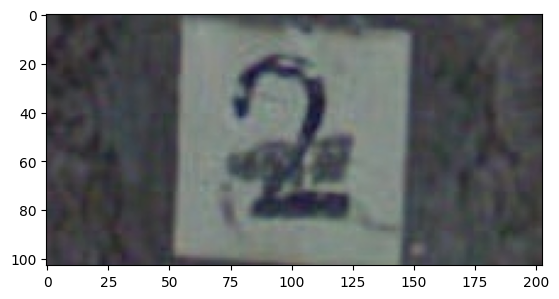

{'labels': [3], 'bboxes': [[68.0, 12.0, 57.0, 74.0]], 'areas': [4218.0], 'iscrowd': 0}


In [ ]:
set_of_image_ids = set()

for element in ann_set:
    if element['image_id'] not in set_of_image_ids:
        set_of_image_ids.add(element['image_id'])

print(set_of_image_ids)

# Create dictonary of annotations
ann_dict = {}
for key in set_of_image_ids:
    target = {}

    labels = []
    bboxes = []
    areas = []
    iscrowd = 0
    for element in ann_set:
        if element['image_id'] == key:

            labels.append(element["category_id"])
            bboxes.append(element["bbox"])
            areas.append(element["area"])
            id = element['id']
            iscrowd = element['iscrowd']

    target['labels'] = labels
    target['bboxes'] = bboxes
    target['areas'] = areas
    target["iscrowd"] = iscrowd

    ann_dict[key] = target
    #print(f"Resulting target: {target}")

# Print a random sample from this dataset
key = random.choice(list(ann_dict))
image = ann_dict[key]
img_location = data_directory + str(key) +'.png'

img = mpimg.imread(img_location)
print(img.shape)
plt.imshow(img)

plt.show()
print(ann_dict[key])

with open('/content/drive/MyDrive/Selected_Topics_HW2/nycu-hw2-data/train_dictionary.json', 'w') as fp:
    json.dump(ann_dict, fp)

(52, 127, 3)


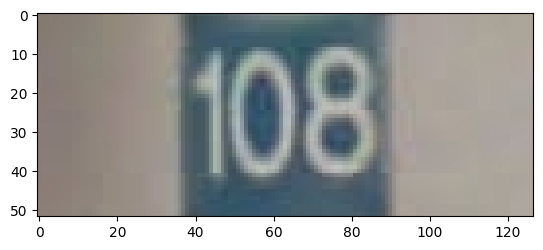

{'labels': [2, 1, 9], 'bboxes': [[41.0, 6.0, 7.0, 37.0], [49.0, 6.0, 20.0, 37.0], [69.0, 4.0, 20.0, 37.0]], 'areas': [259.0, 740.0, 740.0], 'iscrowd': 0}


In [ ]:
f = '/content/drive/MyDrive/Selected_Topics_HW2/nycu-hw2-data/train_dictionary.json'
data_directory = '/content/drive/MyDrive/Selected_Topics_HW2/nycu-hw2-data/train/'

with open(f) as json_data:
    ann_dict = json.load(json_data)
    json_data.close()

key = random.choice(list(ann_dict))
image = ann_dict[key]
img_location = data_directory + str(key) +'.png'
print(img_location)
img = mpimg.imread(img_location)
print(img.shape)
plt.imshow(img)

plt.show()
print(ann_dict[key])

In [ ]:
f_in = '/content/drive/MyDrive/Selected_Topics_HW2/nycu-hw2-data/valid.json'
f_out = '/content/drive/MyDrive/Selected_Topics_HW2/nycu-hw2-data/valid_dictionary.json'
valid_data_directory = '/content/drive/MyDrive/Selected_Topics_HW2/nycu-hw2-data/valid/'

with open(f_in) as json_data:
    d = json.load(json_data)
    ann_set = d['annotations']
    json_data.close()

set_of_image_ids = set()

for element in ann_set:
    if element['image_id'] not in set_of_image_ids:
        set_of_image_ids.add(element['image_id'])

# Create dictonary of annotations
ann_dict = {}
for key in set_of_image_ids:
    target = {}

    labels = []
    bboxes = []
    areas = []
    iscrowd = 0
    for element in ann_set:
        if element['image_id'] == key:

            labels.append(element["category_id"])
            bboxes.append(element["bbox"])
            areas.append(element["area"])
            id = element['id']
            iscrowd = element['iscrowd']

    target['labels'] = labels
    target['bboxes'] = bboxes
    target['areas'] = areas
    target["iscrowd"] = iscrowd

    ann_dict[key] = target
    #print(f"Resulting target: {target}")

# Print a random sample from this dataset
key = random.choice(list(ann_dict))
image = ann_dict[key]
img_location = data_directory + str(key) +'.png'

img = mpimg.imread(img_location)
print(img.shape)
plt.imshow(img)

plt.show()
print(ann_dict[key])

with open(f_out, 'w') as fp:
    json.dump(ann_dict, fp)

NameError: name 'json' is not defined

(44, 120, 3)


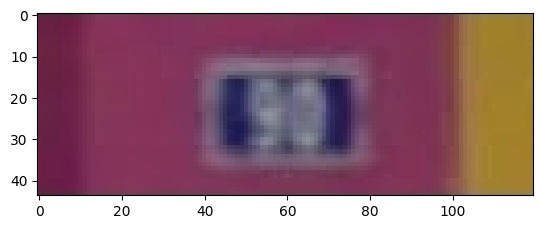

{'labels': [10, 1], 'bboxes': [[47.0, 15.0, 14.0, 22.0], [59.0, 13.0, 15.0, 22.0]], 'areas': [308.0, 330.0], 'iscrowd': 0}


In [ ]:
data_directory = '/content/drive/MyDrive/Selected_Topics_HW2/nycu-hw2-data/valid/'

with open(f_out) as json_data:
    ann_dict = json.load(json_data)
    json_data.close()

key = random.choice(list(ann_dict))
image = ann_dict[key]
img_location = data_directory + str(key) +'.png'
print(img_location)
img = mpimg.imread(img_location)
print(img.shape)
plt.imshow(img)

plt.show()
print(ann_dict[key])

In [ ]:
f_train_out = ROOT_DIR + "/nycu-hw2-data/train_dictionary.json"
f_valid_out =  ROOT_DIR + "/nycu-hw2-data/valid_dictionary.json"

#show a random sample from training set
with open(f_train_out) as json_data:
    ann_train_dict = json.load(json_data)
    json_data.close()

#show a random sample from validation set
with open(f_valid_out) as json_data:
    ann_valid_dict = json.load(json_data)
    json_data.close()

Number of training samples:  30062
showing image:  /content/drive/MyDrive/Selected_Topics_HW2/nycu-hw2-data/train/23755.png
key =  23755
{'labels': [6, 2], 'bboxes': [[50.0, 10.0, 23.0, 53.0], [77.0, 8.0, 13.0, 53.0]], 'areas': [1219.0, 689.0], 'iscrowd': 0}


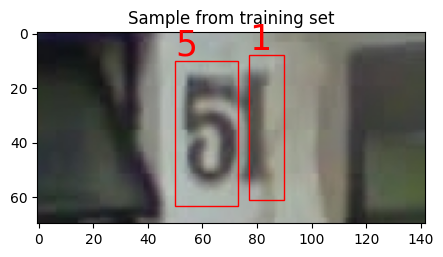

Number of validation samples:  3340
showing image:  /content/drive/MyDrive/Selected_Topics_HW2/nycu-hw2-data/valid/116.png
key =  116
{'labels': [7, 9], 'bboxes': [[45.0, 10.0, 11.0, 35.0], [54.0, 12.0, 14.0, 35.0]], 'areas': [385.0, 490.0], 'iscrowd': 0}


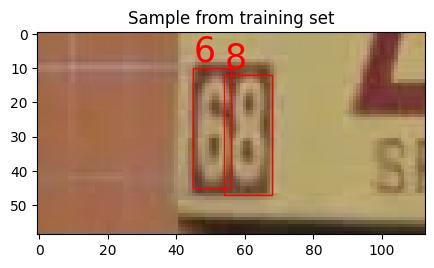

In [ ]:
# show a random sample from training set

print("Number of training samples: ", len(ann_train_dict))
key = random.choice(list(ann_train_dict))
image = ann_train_dict[key]
img_location = TRAIN_DIR + str(key) +'.png'
print("showing image: ", img_location)
img = mpimg.imread(img_location)
img = mpimg.imread(img_location)

print("key = ", key)
print(ann_train_dict[key])

boxes = ann_train_dict[key]['bboxes']
labels = ann_train_dict[key]['labels']

# Create figure and axes
fig, ax = plt.subplots(figsize=(5, 4))

# Display the image
ax.imshow(img)
ax.set_title("Sample from training set")
for box_num, box in enumerate(boxes):
    # # Create a Rectangle patch
    rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(box[0], box[1]-2, CLASSES[labels[box_num] -1], color='red', fontsize=25)
plt.show()

#show a random sample from validation set

print("Number of validation samples: ", len(ann_valid_dict))
key = random.choice(list(ann_valid_dict))
image = ann_valid_dict[key]
img_location = VALID_DIR + str(key) +'.png'
print("showing image: ", img_location)
img = mpimg.imread(img_location)
img = mpimg.imread(img_location)

print("key = ", key)
print(ann_valid_dict[key])

boxes = ann_valid_dict[key]['bboxes']
labels = ann_valid_dict[key]['labels']

# Create figure and axes
fig, ax = plt.subplots(figsize=(5, 4))

# Display the image
ax.imshow(img)
ax.set_title("Sample from training set")
for box_num, box in enumerate(boxes):
    # # Create a Rectangle patch
    rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(box[0], box[1]-2, CLASSES[labels[box_num] -1], color='red', fontsize=25)
plt.show()

In [ ]:
class DigitDataset(Dataset):
    def __init__(self, dir_path, ann_dict, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.ann_dict = ann_dict
        self.height = height
        self.width = width
        self.classes = classes

        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.png")
        self.all_images = [image_path.split('/')[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):

        # capture the image name and the full image path
        image_name = self.all_images[idx]

        key = image_name.split("/")[-1].split(".")[0]

        image_path = os.path.join(self.dir_path, image_name)

        # read the image
        image = cv2.imread(image_path)

        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_width = image.shape[1]
        image_height = image.shape[0]

        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0

        # capture the corresponding element from dictionary
        annotation = self.ann_dict[key]

        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]

        # map the current object name to `classes` list to get the label index and append to `labels` list

        labels = annotation['labels']
        bboxes = annotation['bboxes']
        new_bboxes = []
        for bbox in bboxes:
            # xmin = left corner x-coordinates
            xmin = bbox[0]
            # xmax = right corner x-coordinates
            xmax = bbox[0] + bbox[2]
            # ymin = left corner y-coordinates
            ymin = bbox[1]
            # ymax = right corner y-coordinates
            ymax = bbox[1] + bbox[3]

            # resize the bounding boxes according to the desired `width`, `height`
            xmin_final = np.clip((xmin/image_width)*self.width, 0, self.width)
            xmax_final = np.clip((xmax/image_width)*self.width, 0, self.width)
            ymin_final = np.clip((ymin/image_height)*self.height, 0, self.height)
            ymax_final = np.clip((ymax/image_height)*self.height, 0, self.height)
            #new_bbox = [xmin_final, ymin_final, xmax_final - xmin_final, ymax_final - ymin_final]
            new_bbox = [xmin_final, ymin_final, xmax_final, ymax_final]
            new_bboxes.append(new_bbox)

        # bounding box to tensor
        new_bboxes = torch.as_tensor(new_bboxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (new_bboxes[:, 3] - new_bboxes[:, 1]) * (new_bboxes[:, 2] - new_bboxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((new_bboxes.shape[0],), dtype=torch.int64)
        # labels to tensor

        target = {}
        target["boxes"] = new_bboxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([int(key)])
        target["image_id"] = image_id

        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            labels = [l - 1 for l in labels]
            labels = torch.as_tensor(labels, dtype=torch.int64)
            target['labels'] = labels
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
        return image_resized, target
    def __len__(self):
        return len(self.all_images)

Number of training samples: 30062
Number of training batches: 3758
Number of validation samples: 3340
Number of validation batches: 418
[[ 73   9 120 246]
 [117   9 149 246]
 [149   9 179 246]]


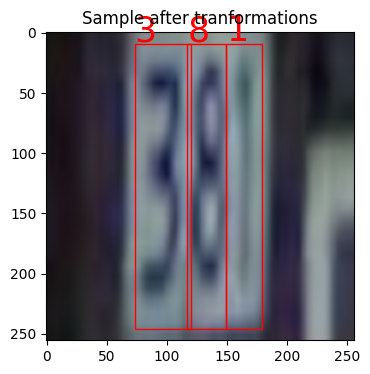

In [ ]:
# prepare the final datasets and data loaders
train_dataset = DigitDataset(TRAIN_DIR, ann_train_dict, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())
valid_dataset = DigitDataset(VALID_DIR, ann_valid_dict, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation samples: {len(valid_dataset)}")
print(f"Number of validation batches: {len(valid_loader)}")

#Show sample from train loader
show_transformed_image(train_loader)

# Model training

In [5]:
def create_model(num_classes):

    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [6]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using ", DEVICE)


Using  cuda


In [ ]:
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list

     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

# initialize the model and move to the computation device
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
paramsum = sum([np.prod(p.size()) for p in model_parameters])
print("Total number of parameters in the network: ", paramsum)

# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
# uncomment if want to use Adam
# optimizer = torch.optim.Adam(params, lr=0.000001)
# uncomment if want to use learning rate scheduler
# my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)

# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
train_loss_list = []
val_loss_list = []
# name to save the trained model with
MODEL_NAME = 'model'

41117761


In [ ]:
def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, OUT_DIR + '/last_modelAdamLR1e-5.pth')

# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()
    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    # uncomment if using learning rate scheduler
    # my_lr_scheduler.step()
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
    # save model
    save_model(epoch, model, optimizer)
    # save loss plot  11q
    save_loss_plot(OUT_DIR, train_loss, val_loss, epoch)


EPOCH 1 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #1 train loss: 0.414
Epoch #1 validation loss: 0.342
Took 163.906 minutes for epoch 0
SAVING PLOTS COMPLETE...

EPOCH 2 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #2 train loss: 0.314
Epoch #2 validation loss: 0.294
Took 15.328 minutes for epoch 1
SAVING PLOTS COMPLETE...

EPOCH 3 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #3 train loss: 0.274
Epoch #3 validation loss: 0.267
Took 15.561 minutes for epoch 2
SAVING PLOTS COMPLETE...

EPOCH 4 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #4 train loss: 0.255
Epoch #4 validation loss: 0.250
Took 15.462 minutes for epoch 3
SAVING PLOTS COMPLETE...

EPOCH 5 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #5 train loss: 0.241
Epoch #5 validation loss: 0.238
Took 15.431 minutes for epoch 4
SAVING PLOTS COMPLETE...

EPOCH 6 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #6 train loss: 0.230
Epoch #6 validation loss: 0.233
Took 15.485 minutes for epoch 5
SAVING PLOTS COMPLETE...

EPOCH 7 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #7 train loss: 0.223
Epoch #7 validation loss: 0.224
Took 15.469 minutes for epoch 6
SAVING PLOTS COMPLETE...

EPOCH 8 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #8 train loss: 0.217
Epoch #8 validation loss: 0.223
Took 15.402 minutes for epoch 7
SAVING PLOTS COMPLETE...

EPOCH 9 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #9 train loss: 0.213
Epoch #9 validation loss: 0.218
Took 15.462 minutes for epoch 8
SAVING PLOTS COMPLETE...

EPOCH 10 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #10 train loss: 0.209
Epoch #10 validation loss: 0.218
Took 15.518 minutes for epoch 9
SAVING PLOTS COMPLETE...

EPOCH 11 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #11 train loss: 0.206
Epoch #11 validation loss: 0.214
Took 15.529 minutes for epoch 10
SAVING PLOTS COMPLETE...

EPOCH 12 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #12 train loss: 0.203
Epoch #12 validation loss: 0.216
Took 15.535 minutes for epoch 11
SAVING PLOTS COMPLETE...

EPOCH 13 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #13 train loss: 0.201
Epoch #13 validation loss: 0.209
Took 15.545 minutes for epoch 12
SAVING PLOTS COMPLETE...

EPOCH 14 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #14 train loss: 0.199
Epoch #14 validation loss: 0.210
Took 15.533 minutes for epoch 13
SAVING PLOTS COMPLETE...

EPOCH 15 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #15 train loss: 0.197
Epoch #15 validation loss: 0.209
Took 15.547 minutes for epoch 14
SAVING PLOTS COMPLETE...

EPOCH 16 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #16 train loss: 0.195
Epoch #16 validation loss: 0.208
Took 15.537 minutes for epoch 15
SAVING PLOTS COMPLETE...

EPOCH 17 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #17 train loss: 0.192
Epoch #17 validation loss: 0.205
Took 15.552 minutes for epoch 16
SAVING PLOTS COMPLETE...

EPOCH 18 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #18 train loss: 0.192
Epoch #18 validation loss: 0.210
Took 15.538 minutes for epoch 17
SAVING PLOTS COMPLETE...

EPOCH 19 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #19 train loss: 0.190
Epoch #19 validation loss: 0.206
Took 15.548 minutes for epoch 18
SAVING PLOTS COMPLETE...

EPOCH 20 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #20 train loss: 0.189
Epoch #20 validation loss: 0.205
Took 15.564 minutes for epoch 19
SAVING PLOTS COMPLETE...

EPOCH 21 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #21 train loss: 0.187
Epoch #21 validation loss: 0.204
Took 15.536 minutes for epoch 20
SAVING PLOTS COMPLETE...

EPOCH 22 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #22 train loss: 0.185
Epoch #22 validation loss: 0.203
Took 15.551 minutes for epoch 21
SAVING PLOTS COMPLETE...

EPOCH 23 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #23 train loss: 0.184
Epoch #23 validation loss: 0.205
Took 15.562 minutes for epoch 22
SAVING PLOTS COMPLETE...

EPOCH 24 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #24 train loss: 0.183
Epoch #24 validation loss: 0.203
Took 15.543 minutes for epoch 23
SAVING PLOTS COMPLETE...

EPOCH 25 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #25 train loss: 0.182
Epoch #25 validation loss: 0.204
Took 15.557 minutes for epoch 24
SAVING PLOTS COMPLETE...

EPOCH 26 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #26 train loss: 0.181
Epoch #26 validation loss: 0.204
Took 15.572 minutes for epoch 25
SAVING PLOTS COMPLETE...

EPOCH 27 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #27 train loss: 0.179
Epoch #27 validation loss: 0.204
Took 15.566 minutes for epoch 26
SAVING PLOTS COMPLETE...

EPOCH 28 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #28 train loss: 0.178
Epoch #28 validation loss: 0.204
Took 15.576 minutes for epoch 27
SAVING PLOTS COMPLETE...

EPOCH 29 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #29 train loss: 0.177
Epoch #29 validation loss: 0.204
Took 15.552 minutes for epoch 28
SAVING PLOTS COMPLETE...

EPOCH 30 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

Validating


  0%|          | 0/418 [00:00<?, ?it/s]

Epoch #30 train loss: 0.176
Epoch #30 validation loss: 0.206
Took 15.575 minutes for epoch 29
SAVING PLOTS COMPLETE...

EPOCH 31 of 100
Training


  0%|          | 0/3758 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Test

In [7]:
import time
import json
import glob as glob
from pprint import pprint
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(data, key=alphanum_key)

# load the best model and trained weights
model = create_model(num_classes=NUM_CLASSES)
#checkpoint = torch.load(OUT_DIR + '/outputs/last_model_epoch60.pth', map_location=DEVICE)
checkpoint = torch.load(OUT_DIR + '/last_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()
# directory where all the images are present
DIR_TEST = '/content/drive/MyDrive/Selected_Topics_HW2/nycu-hw2-data/test/'
#DIR_TEST = VALID_DIR
test_images = glob.glob(f"{DIR_TEST}/*.png")
test_images = sorted_alphanumeric(test_images)
print(f"Test instances: {len(test_images)}")
# define the detection threshold...
# ... any detection having score below this will be discarded
detection_threshold = 0.75
# to count the total number of images iterated through
image_count = 0

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test instances: 13068


final prediction:  -1
Image 1 done...
--------------------------------------------------


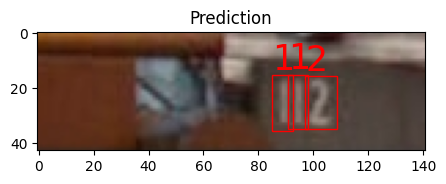

final prediction:  112
Image 2 done...
--------------------------------------------------


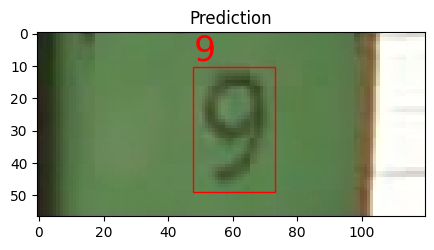

final prediction:  9
Image 3 done...
--------------------------------------------------
final prediction:  -1
Image 4 done...
--------------------------------------------------


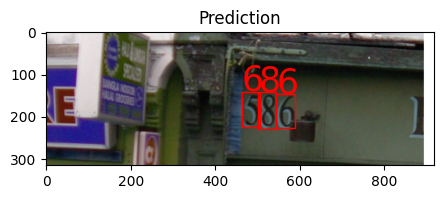

final prediction:  686
Image 5 done...
--------------------------------------------------


In [9]:
# view example of test prediction on 5 images
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pandas as pd

pred_dict = []
image_id_list = []
pred_label_list = []

for i in range(5):
    # get the image file name for saving output later on
    image_name = test_images[i].split(os.path.sep)[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    # save original dimensions before transform
    width = image.shape[1]
    height = image.shape[0]
    orig_image = image.copy()
    # resize image
    image = cv2.resize(image, (RESIZE_TO, RESIZE_TO))
    # BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image.to(DEVICE))
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

    image_id_list.append(int(image_name))
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        boxes = boxes
        draw_boxes = boxes.copy()

        if len(boxes) != 0:
            # get all the predicited class names
            pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
            fig, ax = plt.subplots(figsize=(5, 4))

            # Display the image
            ax.imshow(orig_image)
            ax.set_title("Prediction")
            # draw the bounding boxes and write the class name on top of it

            class_name_list = []
            xmin_list = []
            for j, box in enumerate(draw_boxes):
                # resize the bounding boxes according to the desired `width`, `height`
                xmin_final = box[0] * width /RESIZE_TO
                xmax_final = box[2]  * width /RESIZE_TO
                ymin_final = box[1] * height /RESIZE_TO
                ymax_final =  box[3] * height /RESIZE_TO

                new_box = [xmin_final, ymin_final, xmax_final, ymax_final]
                box = new_box
                class_name = pred_classes[j]
                class_name_list.append(pred_classes[j])
                xmin_list.append(xmin_final)
                rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(box[0], box[1]-2, class_name, color='red', fontsize=25)

            _, list2 = zip(*sorted(zip(xmin_list, class_name_list)))
            list2 = "".join(list2)
            pred_label_list.append(int(list2))
            plt.show()

        else:
            pred_label_list.append(-1)

    else:
        pred_label_list.append(-1)

    print("final prediction: ", pred_label_list[-1])
    print(f"Image {i+1} done...")
    print('-'*50)


In [10]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pandas as pd

pred_dict = []
image_id_list = []
pred_label_list = []
prog_bar = tqdm(test_images, total=len(test_images))

for i, data in enumerate(prog_bar):
#for i in range(5):
    # get the image file name for saving output later on
    image_name = test_images[i].split(os.path.sep)[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    # save original dimensions before transform
    width = image.shape[1]
    height = image.shape[0]
    orig_image = image.copy()
    # resize image
    image = cv2.resize(image, (RESIZE_TO, RESIZE_TO))
    # BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image.to(DEVICE))
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

    image_id_list.append(int(image_name))
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        boxes = boxes
        draw_boxes = boxes.copy()

        if len(boxes) != 0:
            # get all the predicited class names
            pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
            class_name_list = []
            xmin_list = []
            for j, box in enumerate(draw_boxes):
                # resize the bounding boxes according to the desired `width`, `height`
                xmin_final = box[0] * width /RESIZE_TO
                xmax_final = box[2]  * width /RESIZE_TO
                ymin_final = box[1] * height /RESIZE_TO
                ymax_final =  box[3] * height /RESIZE_TO

                new_box = [xmin_final, ymin_final, xmax_final, ymax_final]
                box = new_box
                class_name = pred_classes[j]
                class_name_list.append(pred_classes[j])
                xmin_list.append(xmin_final)
                prediction = {
                    "image_id":int(image_name),
                    "bbox":[float(box[0]), float(box[1]), float(box[2]-box[0]), float(box[3]-box[1])],
                    "score":float(scores[j]),
                    "category_id":int(class_name) + 1,
                }
                pred_dict.append(prediction)
            _, list2 = zip(*sorted(zip(xmin_list, class_name_list)))
            list2 = "".join(list2)
            pred_label_list.append(int(list2))
            plt.show()

        else:
            pred_label_list.append(-1)

    else:
        pred_label_list.append(-1)

print('TEST PREDICTIONS COMPLETE')

dict = {'image_id': image_id_list, 'pred_label': pred_label_list}
df = pd.DataFrame(dict)
df.to_csv('/content/drive/MyDrive/Selected_Topics_HW2/outputs/pred.csv', index=False)

with open('/content/drive/MyDrive/Selected_Topics_HW2/outputs/pred.json', 'w')as file:
    file.write(json.dumps(pred_dict, indent=4))

  0%|          | 0/13068 [00:00<?, ?it/s]

TEST PREDICTIONS COMPLETE
